# Let's do it!

# Data loading and preprocessing

In [1]:
import numpy as np
import torch

***The function to check memory on your server***

In [2]:
def memory():
    try:
        !nvidia-smi    
    except:
        pass

***Next two objects below we used to load data from the necessary directory***

In [4]:
from PIL import Image


class ImageLoader():
    def __init__(self, transform=None):
        self.transform = transform

    def load(self, path):
        out = Image.open(path).convert('RGB')

        if self.transform is not None:
            out = self.transform(out)

        return out 

In [5]:
import os
import glob

from torch.utils.data import Dataset


class ImageDataset(Dataset):
    def __init__(self, root, load_percent=1, padding=0, transform=None):
        self.transform = transform
        self.loader = ImageLoader(transform)
        
        self.paths = self.get_paths(root)
        
        start = int(len(self.paths) * padding)
        end = start + int(len(self.paths) * load_percent)
        self.paths = self.paths[start:end]
        
    def get_paths(self, root):
        path = os.path.join(root, '*')
        paths = glob.glob(path)
        
        exts = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        paths = filter(lambda p: p.endswith(exts), paths)
        paths = list(paths)
        
        return paths

    def __getitem__(self, index):
        path = self.paths[index]
        img = self.loader.load(path)
        return img

    def __len__(self):
        return len(self.paths)

***The functions to get contures from the image***

In [6]:
import cv2 as cv


def tensor_to_cv(x):
    x = x.detach().cpu().numpy()
    x = (x + 1) / 2
    x = x.transpose(1, 2, 0)

    x = (x * 255).astype(np.uint8)
    x = cv.cvtColor(x, cv.COLOR_BGR2GRAY)

    return x


def cv_to_tensor(x):
    x = x / 255.0

    x = x[None, :, :]
    x = 2 * x - 1
    x = torch.FloatTensor(x)
    
    x = x.view((x.shape[0], 1, *x.shape[1:]))

    return x


def auto_canny(image, sigma=0.33):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    
    edged = cv.Canny(image, lower, upper)

    return edged


def to_edge(x):
    device = x.device

    x = tensor_to_cv(x)
    x = cv.blur(x, (5, 5))
    x = auto_canny(x)
    x = cv_to_tensor(x)
    x = x.to(device)

    return x

***The object to get contures from image***

In [7]:
class EdgeDatasetWrapper(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        x = self.dataset[index]
        x_edge = to_edge(x)
        return x, x_edge

    def __len__(self):
        return len(self.dataset)    

***The function to transform data with augmentation ability***

In [8]:
import torchvision.transforms as transforms


def get_transform(image_size, aug=False):
    if aug:
        bigger_image_size = (image_size // 8 + 1) * 8
        ts = [
            transforms.Resize((bigger_image_size, bigger_image_size)),
            transforms.RandomResizedCrop((image_size, image_size)),
            transforms.RandomHorizontalFlip()
        ]
    else:
        ts = [transforms.Resize((image_size, image_size))]
        
    ts += [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]
    
    return transforms.Compose(ts)

***Loading and transforming data***

In [75]:
# don't change the value of this variable!
image_size = 256

train_transforms = get_transform(image_size, aug=True)
train_dataset = ImageDataset(root='./Cats', load_percent=0.9, transform=train_transforms)
train_dataset = EdgeDatasetWrapper(train_dataset)

val_transforms = get_transform(image_size, aug=False)
val_dataset = ImageDataset(root='./Cats', padding=0.9, load_percent=0.1, transform=val_transforms)
val_dataset = EdgeDatasetWrapper(val_dataset)

In [76]:
def collate_fn(data):
    x1, x2 = zip(*data)

    x1 = torch.stack(x1, dim=0)
    x2 = torch.stack(x2, dim=0)

    return x1, x2

***Finally we have train and val loaders!***

In [102]:
from torch.utils.data import DataLoader

batch_size = 1


trainloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn,
    drop_last=True
)

valloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn,
    drop_last=True
)

***Use GPU to make calculates faster***

In [78]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

***Use wandb to log code***

In [79]:
! pip install wandb

***The functions to make the process of writing neural networks more comfortable and flexible***

In [80]:
from torch import nn
from torch.nn import Sequential as Seq

In [81]:
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1,
                     stride=stride)

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3,
                     stride=stride, padding=1)

def conv4x4(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=4,
                     stride=stride, padding=1)

def conv5x5(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=5,
                     stride=stride, padding=2)

def conv7x7(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=7,
                     stride=stride, padding=3)

In [82]:
def conv_by_name(kernel_size):
    if kernel_size == '1x1':
        return conv1x1
    elif kernel_size == '3x3':
        return conv3x3
    elif kernel_size == '4x4':
        return conv4x4
    elif kernel_size == '5x5':
        return conv5x5
    elif kernel_size == '7x7':
        return conv7x7

In [83]:
def activ_by_name(name):
    if name == 'relu':
        return nn.ReLU6()
    elif name == 'lerelu':
        return nn.LeakyReLU(0.2)
    

In [84]:
def transp1x1(in_planes, out_planes, stride=1):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=1,
                     stride=stride)

def transp3x3(in_planes, out_planes, stride=1):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=2,
                     stride=stride, padding=0)

def transp4x4(in_planes, out_planes, stride=1):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4,
                     stride=stride, padding=0)

def transp5x5(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=5,
                     stride=stride, padding=0)

def transp7x7(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=7,
                     stride=stride, padding=0)

In [85]:
def transp1x1(in_planes, out_planes, stride=1):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=1,
                     stride=stride)

def transp3x3(in_planes, out_planes, stride=1):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=2,
                     stride=stride, padding=0)

def transp4x4(in_planes, out_planes, stride=1):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4,
                     stride=stride, padding=0)

def transp5x5(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=5,
                     stride=stride, padding=0)

def transp7x7(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=7,
                     stride=stride, padding=0)

In [86]:
def tranpose_by_name(kernel_size):
    if kernel_size == '1x1':
        return transp1x1
    elif kernel_size == '3x3':
        return transp3x3
    elif kernel_size == '4x4':
        return transp4x4
    elif kernel_size == '5x5':
        return transp5x5
    elif kernel_size == '7x7':
        return transp7x7

***We wrote this block, but we didn't use it***

In [107]:
# class ResCompressBlock(nn.Module):
    
#     def __init__(self, in_channels, out_channels, kernel_size, stride=1, activ_name='relu'):
#         super(ResCompressBlock, self).__init__()
#         self.layer1 = Seq(
#             conv_by_name(kernel_size)(in_channels, out_channels, stride),
#             nn.BatchNorm2d(out_channels),
#             activ_by_name(activ_name),
#         )
    
#     def forward(self, x):
        
#         identity = x
        
#         x = self.layer1(x)
        
#         x = torch.cat(identity, x, dim=1)
        
#         return x

In [108]:
class CompressBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, apply_batchnorm=True, stride=2, activ_name='lerelu'):
        super(CompressBlock, self).__init__()
        self.layer1 = Seq()
        self.layer1.add_module('conv', conv_by_name(kernel_size)(in_channels, out_channels, stride)),
        if apply_batchnorm:
            self.layer1.add_module('batch', nn.BatchNorm2d(out_channels)),
        self.layer1.add_module('relu', activ_by_name(activ_name)),

    def forward(self, x):
        
        x = self.layer1(x)
        
        return x

In [109]:
class ExpandBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=2, apply_dropout=False, activ_name='lerelu'):
        super(ExpandBlock, self).__init__()
        self.layer1 = Seq()
        self.layer1.add_module('conv', tranpose_by_name(kernel_size)(in_channels, out_channels, stride)),
        if apply_dropout:
            self.layer1.add_module('batch', nn.BatchNorm2d(out_channels)),
        self.layer1.add_module('relu', activ_by_name(activ_name))
    
    def forward(self, x):
        
        x = self.layer1(x)
        
        return x

# Models

***let's play with architecture***

In [110]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.layer1 = Seq(
            CompressBlock(4, 64, '4x4', False),
            CompressBlock(64, 128, '4x4'),
            CompressBlock(128, 256, '4x4'),
            nn.ZeroPad2d(1),
            nn.Conv2d(256, 512, 4),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.ZeroPad2d(1),
            nn.Conv2d(512, 1, 4),
            
            nn.Flatten(),
            nn.Linear(900, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, y):
        x = torch.cat((y, x), dim=1)
        
        x = self.layer1(x)
        
        return x

In [111]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.layer1 = nn.ModuleList([
            CompressBlock(1, 64, '4x4', apply_batchnorm=False),
            CompressBlock(64, 128, '4x4'),     #64x64
            CompressBlock(128, 256, '4x4'),    #32x32
            CompressBlock(256, 512, '4x4'),    #16x16
            CompressBlock(512, 512, '4x4'),    #8x8
            CompressBlock(512, 512, '4x4'),    #4x4
            CompressBlock(512, 512, '4x4'),    #2x2
        ])
        self.layer2 = nn.ModuleList([
            ExpandBlock(1024, 512, '3x3', apply_dropout=True),
            ExpandBlock(1024, 512, '3x3', apply_dropout=True),  
            ExpandBlock(1024, 512, '3x3', apply_dropout=True),  
            ExpandBlock(1024, 256, '3x3'),  
            ExpandBlock(512, 128, '3x3'),  
            ExpandBlock(256, 64, '3x3'), 
            nn.ConvTranspose2d(128, 3, 4, 2, 1)
        ])
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        
        skips = []
        for layer in self.layer1:
            x = layer(x)
            skips.append(x)
        
        skips = reversed(skips)
        for layer, skip in zip(self.layer2, skips):
            x = torch.cat((x, skip), dim=1)
            x = layer(x)
        
        x = self.tanh(x)
        
        return x

***The functions to log losses and images***

In [112]:
def log_gen_losses(title, losses, step):
    title = f'{title}_gen_losses'

    loss_names = ['loss_fake', 'loss_total']
    
    for loss, loss_name in zip(losses, loss_names):
        wandb.log({f'{title}/{loss_name}': loss}, step=step)

In [113]:
def log_dis_losses(title, losses, step):
    title = f'{title}_dis_losses'

    loss_names = ['loss_real', 'loss_fake', 'loss_total']
    
    for loss, loss_name in zip(losses, loss_names):
        wandb.log({f'{title}/{loss_name}': loss}, step=step)

In [114]:
from torchvision.utils import make_grid

@torch.no_grad()
def log_images(title, name, x, step):
    title = f'{title}_images'

    imgs = make_grid(x, nrow=5)

    wandb.log({f'{title}/{name}': [wandb.Image(imgs)]}, step=step)

***Functions to calculate losses***

In [115]:
def calc_gen_losses(gen, dis, x_real, criterion):

    x_edge_raw = [to_edge(i) for i in x_real]
    x_edge = torch.cat(x_edge_raw).to(device)
    x_fake = gen(x_edge)
    
    out_fake = dis(x_fake, x_edge)

    target_real = torch.ones_like(out_fake).to(device)

    loss_fake = criterion(out_fake, target_real)

    loss_total = loss_fake

    losses = np.array([loss_fake.item(), loss_total.item()])

    return losses, loss_total

In [116]:
def calc_dis_losses(gen, dis, x_real, criterion):

    x_edge_raw = [to_edge(i) for i in x_real]
    x_edge = torch.cat(x_edge_raw).to(device)
    
    x_fake = gen(x_edge).detach()
    
    out_real = dis(x_real, x_edge)
    out_fake = dis(x_fake, x_edge)

    target_real = torch.ones_like(out_real).to(device)
    target_fake = torch.zeros_like(out_fake).to(device)

    loss_real = criterion(out_real, target_real)
    loss_fake = criterion(out_fake, target_fake)

    loss_total = loss_real + loss_fake

    losses = np.array([loss_real.item(), loss_fake.item(), loss_total.item()])

    return losses, loss_total

# Train functions

In [117]:
def train_step(gen, dis, x, criterion, optim_gen, optim_dis, step):
    dis_losses, dis_loss_total = calc_dis_losses(gen, dis, x, criterion)

    optim_dis.zero_grad()
    dis_loss_total.backward()
    optim_dis.step()

    gen_losses, gen_loss_total = calc_gen_losses(gen, dis, x, criterion)

    optim_gen.zero_grad()
    gen_loss_total.backward()
    optim_gen.step()
    log_gen_losses('Train', gen_losses, step)
    log_dis_losses('Train', dis_losses, step)

In [118]:
from tqdm.auto import trange, tqdm


def train_epoch(gen, dis, criterion, optim_gen, optim_dis, dataloader, num_save, step):
    gen.train()
    dis.train()

    for x, _ in tqdm(dataloader):
        x = x.to(device)

        train_step(gen, dis, x, criterion, optim_gen, optim_dis, step)
        
        x_edge_raw = [to_edge(i) for i in x]
        x_edge = torch.cat(x_edge_raw).to(device)

        x_fake = gen(x_edge).detach()
        
#         you may uncomment this block if you want periodically save your models
        
#         if step % 2000 == 0:
#             torch.save(gen, 'SAVED_MODELS/GENERATOR_'+str(num_save))
#             torch.save(dis, 'SAVED_MODELS/DISCRIMINATOR_'+str(num_save))
#             num_save += 1
        
        if step % 200 == 0:
            log_images('Images', 'real', x, step)
            log_images('Images', 'edge', x_edge, step)
            log_images('Images', 'fake', x_fake, step)
        step += 1

    return step, num_save


In [119]:
def train(gen, dis, criterion, optim_gen, optim_dis, trainloader, valloader, epochs):
    step = 0
    num_save = 1
    for epoch in range(epochs):
        step, num_save = train_epoch(gen, dis, criterion, optim_gen, optim_dis, trainloader, num_save, step)

        wandb.log({'epoch': epoch}, step=step)

# The main cell of the code

***You may try to play with hyperparameters, loss function and optimizer***

In [120]:
import wandb

In [121]:
gen = Generator()
dis = Discriminator()
gen.to(device)
dis.to(device)

criterion = nn.BCELoss()

optim_gen = torch.optim.Adam(gen.parameters(), lr=0.0003, betas=(0.5, 0.999))
optim_dis = torch.optim.Adam(dis.parameters(), lr=0.0003, betas=(0.5, 0.999))

wandb.init(project='pix-2-pix')

train(gen, dis, criterion, optim_gen, optim_dis, trainloader, valloader, epochs=100)

KeyboardInterrupt: 

# Thank you for checking our code :)

# P.S. We didn't pay attention to validation here, but you're welcome!

# The sample of logging images:

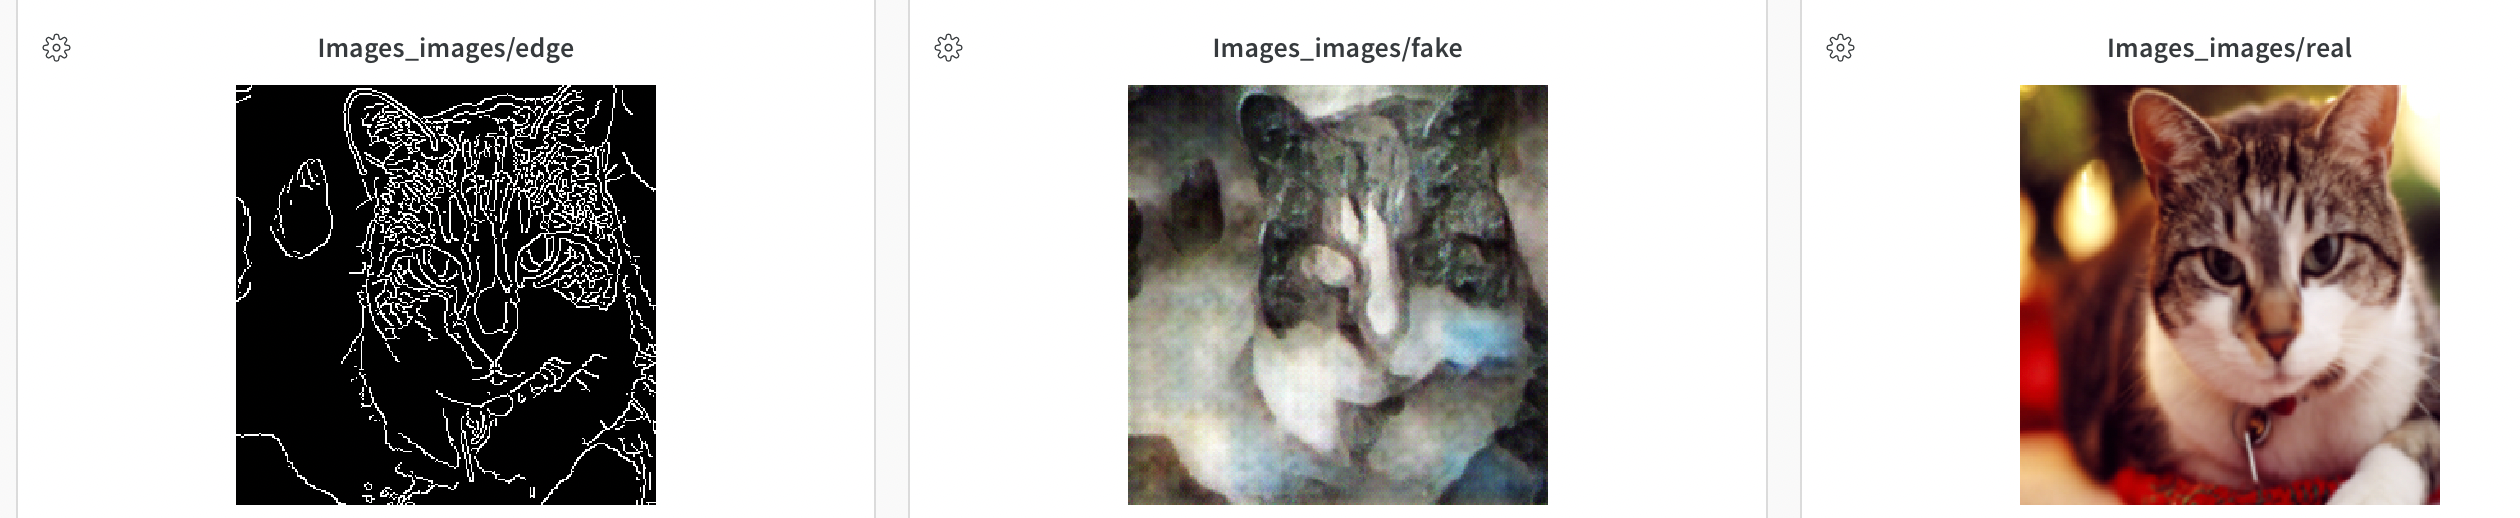

# The samples of reversing black-white picture to colored picture

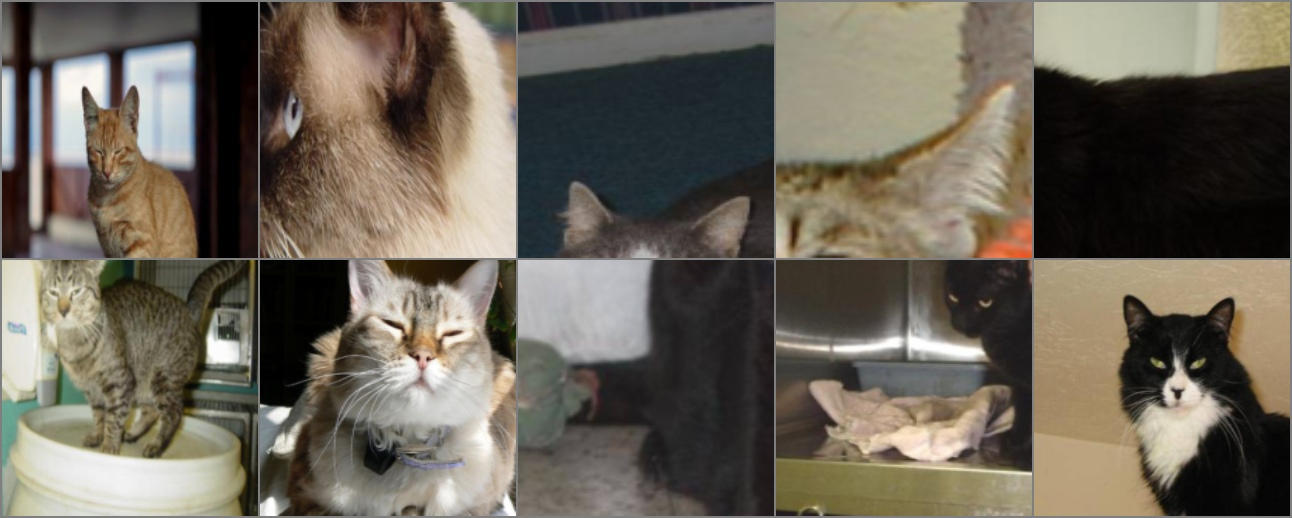

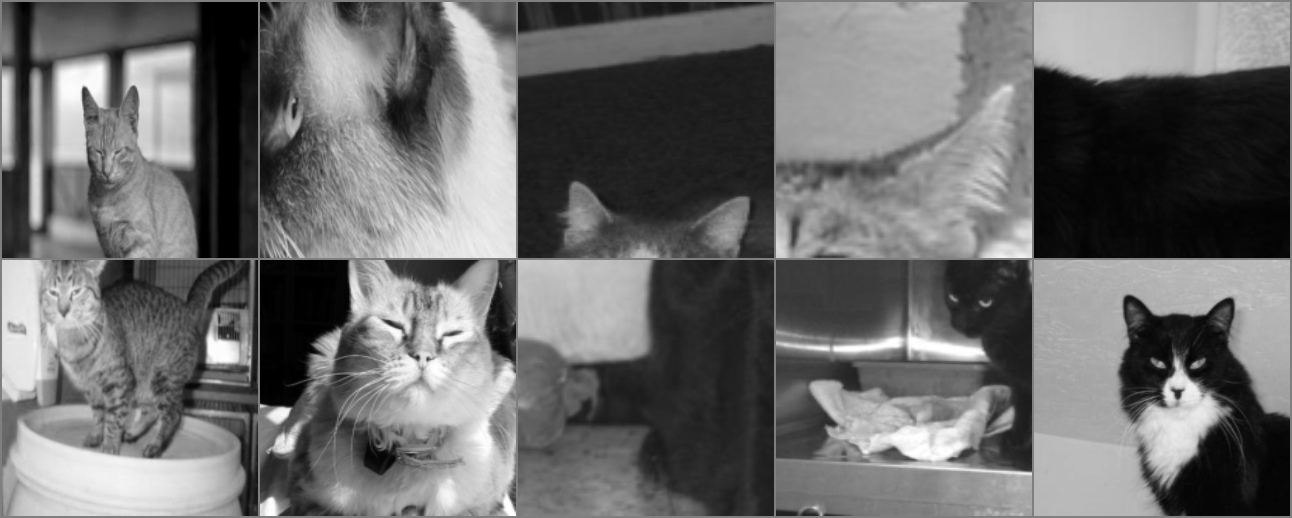

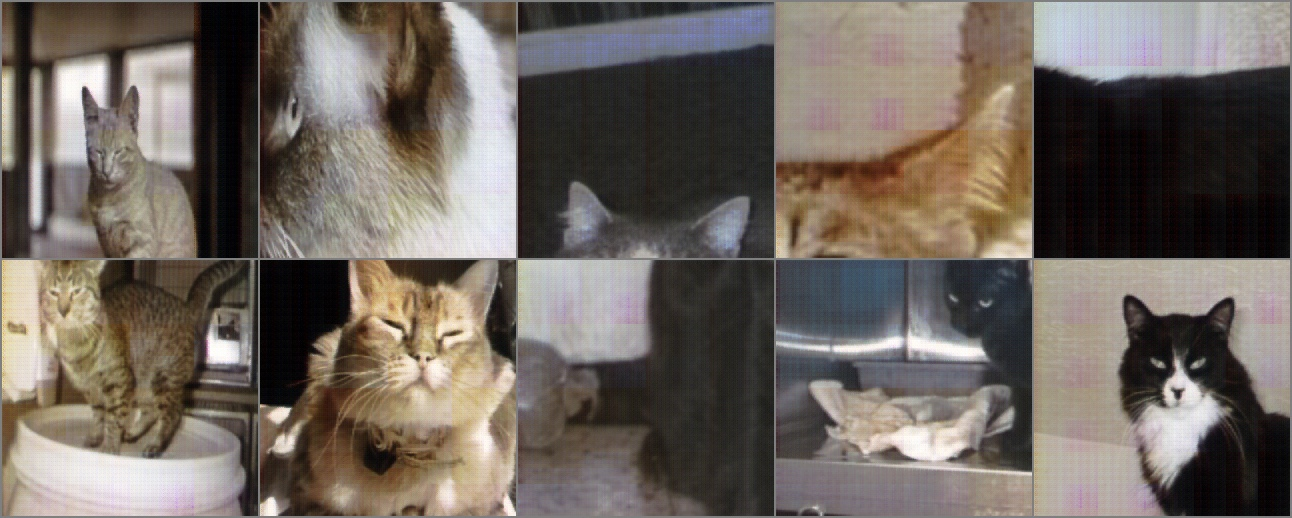

May look at our presentation here: https://docs.google.com/presentation/d/1J0gYhN23GtYcLcpseAH93_p7zxjmvSXyVxVThQvwbPE/edit?usp=sharing